In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers.wrappers import TimeDistributed
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline  

In [281]:
def train_test_split(data, p=None):
    if p:
        split_index = int(len(data) * p)

    train = data[:split_index]
    test = data[split_index:]
    return train, test, split_index

In [3]:
def lag_data(data, lag=1):
    data = list(data)
    X, y = [], []
    for i in range(len(data) - lag - 1):
        a = data[i: i + lag]
        X.append(a)
        y.append(data[i + lag])
    return np.array(X), np.array(y)

In [271]:
def create_simple_network_retain_state(lags, batch_size, retain_state):
    model = Sequential()
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(14, batch_input_shape=(batch_size, lags, 1), stateful=retain_state))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [124]:
lags = 28
output = 7

# Arrivals

In [23]:
arr = pd.read_csv("../data/Sample/333_arrivals.csv", header=None)[1]
arr.head()

0     2
1    21
2    13
3     5
4     7
Name: 1, dtype: int64

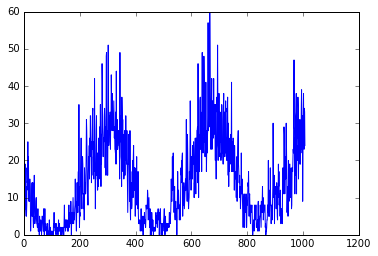

In [24]:
plt.plot(arr)
plt.show()

# 1-Step Forecast

In [289]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.read_csv("../data/Sample/333_arrivals.csv", header=None)[1]
data = scaler.fit_transform(data)
train, test, split_index = train_test_split(data, p=0.7)
X_train, y_train = lag_data(train, lag=lags)
X_test, y_test = lag_data(test, lag=lags)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# model = create_simple_network(lags)
# model.fit(X_train, y_train, nb_epoch=100, batch_size=14, verbose=0, retain_state=False)

batch_size = 6
model = create_simple_network_retain_state(lags, batch_size, retain_state=True)

for i in range(100):
    model.fit(X_train, y_train, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()


Epoch 1/1
1s - loss: 0.0166
Epoch 1/1
1s - loss: 0.0207
Epoch 1/1
1s - loss: 0.0224
Epoch 1/1
1s - loss: 0.0254
Epoch 1/1
1s - loss: 0.0395
Epoch 1/1
2s - loss: 0.0375
Epoch 1/1
1s - loss: 0.0385
Epoch 1/1
1s - loss: 0.0234
Epoch 1/1
1s - loss: 0.0200
Epoch 1/1
1s - loss: 0.0208
Epoch 1/1
1s - loss: 0.0181
Epoch 1/1
2s - loss: 0.0176
Epoch 1/1
1s - loss: 0.0197
Epoch 1/1
1s - loss: 0.0176
Epoch 1/1
2s - loss: 0.0176
Epoch 1/1
1s - loss: 0.0163
Epoch 1/1
1s - loss: 0.0163
Epoch 1/1
1s - loss: 0.0167
Epoch 1/1
1s - loss: 0.0166
Epoch 1/1
1s - loss: 0.0166
Epoch 1/1
1s - loss: 0.0149
Epoch 1/1
1s - loss: 0.0152
Epoch 1/1
1s - loss: 0.0157
Epoch 1/1
1s - loss: 0.0157
Epoch 1/1
1s - loss: 0.0149
Epoch 1/1
1s - loss: 0.0146
Epoch 1/1
1s - loss: 0.0145
Epoch 1/1
1s - loss: 0.0155
Epoch 1/1
1s - loss: 0.0147
Epoch 1/1
1s - loss: 0.0147
Epoch 1/1
1s - loss: 0.0143
Epoch 1/1
1s - loss: 0.0150
Epoch 1/1
1s - loss: 0.0138
Epoch 1/1
1s - loss: 0.0144
Epoch 1/1
1s - loss: 0.0140
Epoch 1/1
1s - loss:

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [290]:
train_preds = model.predict(X_train, batch_size=batch_size)
test_preds = model.predict(X_test, batch_size=batch_size)

train_preds = scaler.inverse_transform(train_preds)
y_train = scaler.inverse_transform(y_train)
test_preds = scaler.inverse_transform(test_preds)
y_test = scaler.inverse_transform(y_test)

train_score = math.sqrt(mean_squared_error(y_train, train_preds))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_preds))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 6.93 RMSE
Test Score: 6.65 RMSE


/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


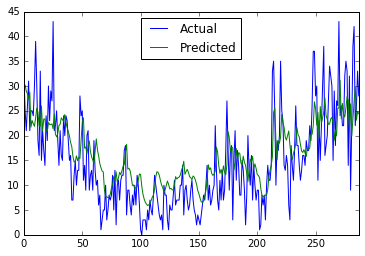

In [298]:
results = pd.concat([pd.Series(y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

# Departures

In [293]:
dep = pd.read_csv("../data/Sample/333_departures.csv", header=None)[1]
dep.head()

0     3
1    18
2     6
3     6
4     9
Name: 1, dtype: int64

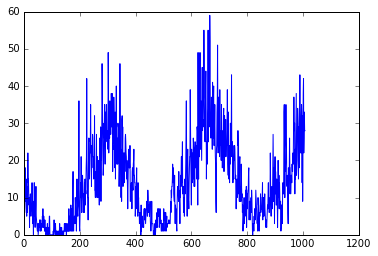

In [294]:
plt.plot(dep)
plt.show()

In [295]:
scaler = MinMaxScaler(feature_range=(0, 1))
model = create_simple_network(lags)
data = pd.read_csv("../data/Sample/333_departures.csv", header=None)[1]
data = scaler.fit_transform(data)
train, test, split_index = train_test_split(data, p=0.7)
X_train, y_train = lag_data(train, lag=lags)
X_test, y_test = lag_data(test, lag=lags)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# model = create_simple_network(lags)
# model.fit(X_train, y_train, nb_epoch=100, batch_size=14, verbose=0, retain_state=False)

batch_size = 6
model = create_simple_network_retain_state(lags, batch_size, retain_state=True)

for i in range(100):
    model.fit(X_train, y_train, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()


Epoch 1/1
1s - loss: 0.0165
Epoch 1/1
1s - loss: 0.0240
Epoch 1/1
1s - loss: 0.0287
Epoch 1/1
1s - loss: 0.0269
Epoch 1/1
1s - loss: 0.0331
Epoch 1/1
1s - loss: 0.0358
Epoch 1/1
1s - loss: 0.0362
Epoch 1/1
1s - loss: 0.0534
Epoch 1/1
1s - loss: 0.0577
Epoch 1/1
1s - loss: 0.0436
Epoch 1/1
1s - loss: 0.0290
Epoch 1/1
1s - loss: 0.0221
Epoch 1/1
1s - loss: 0.0222
Epoch 1/1
1s - loss: 0.0225
Epoch 1/1
1s - loss: 0.0200
Epoch 1/1
1s - loss: 0.0200
Epoch 1/1
2s - loss: 0.0184
Epoch 1/1
1s - loss: 0.0190
Epoch 1/1
1s - loss: 0.0189
Epoch 1/1
1s - loss: 0.0170
Epoch 1/1
1s - loss: 0.0170
Epoch 1/1
1s - loss: 0.0168
Epoch 1/1
1s - loss: 0.0178
Epoch 1/1
1s - loss: 0.0168
Epoch 1/1
1s - loss: 0.0173
Epoch 1/1
1s - loss: 0.0162
Epoch 1/1
1s - loss: 0.0173
Epoch 1/1
1s - loss: 0.0166
Epoch 1/1
1s - loss: 0.0165
Epoch 1/1
1s - loss: 0.0165
Epoch 1/1
1s - loss: 0.0158
Epoch 1/1
1s - loss: 0.0158
Epoch 1/1
1s - loss: 0.0164
Epoch 1/1
1s - loss: 0.0178
Epoch 1/1
1s - loss: 0.0161
Epoch 1/1
2s - loss:

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [297]:
train_preds = model.predict(X_train, batch_size=batch_size)
test_preds = model.predict(X_test, batch_size=batch_size)

train_preds = scaler.inverse_transform(train_preds)
y_train = scaler.inverse_transform(y_train)
test_preds = scaler.inverse_transform(test_preds)
y_test = scaler.inverse_transform(y_test)

train_score = math.sqrt(mean_squared_error(y_train, train_preds))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_preds))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 6.66 RMSE
Test Score: 6.59 RMSE


/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


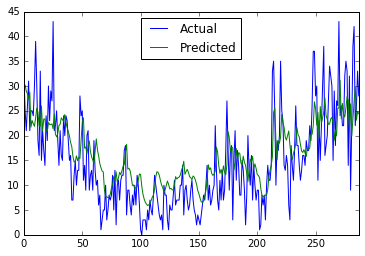

In [299]:
results = pd.concat([pd.Series(y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()